In [1]:
%matplotlib inline

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Keep part in this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! 

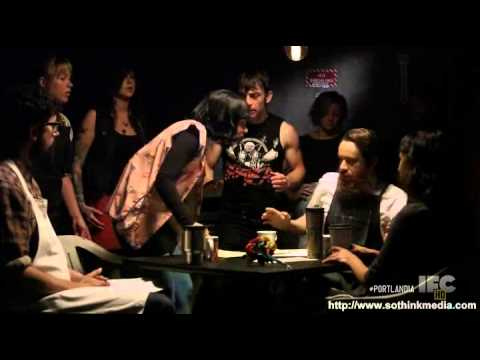

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [3]:
%pwd

'/mnt/c/Users/Asura/Documents/Programming Projects/LSDS/DS-Unit-4-Sprint-1-NLP/module1-text-data'

## Imports

In [4]:
import pandas as pd
# ---------------- Pandas settings --------------- #
# Removes rows and columns truncation of '...'
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import squarify
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokenizer import Tokenizer

from collections import Counter

nlp = spacy.load('en_core_web_lg')

### Load the `reviews`

In [5]:
url = "data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


## Wrangle

#### Remove `' star rating'` from `star_rating` column, convert to `float`

In [6]:
shops['rating'] = shops['star_rating'].str.replace(' star rating', '').astype('float')
del shops['star_rating']
shops['rating'].value_counts(normalize=True).to_frame()

,rating
5.0,0.496324
4.0,0.309874
3.0,0.096901
2.0,0.060399
1.0,0.036502


#### Extract `date` from `full_review_text` column to new date column, convert to `datetime`

In [7]:
shops['date'] = shops['full_review_text'].str.split(expand=True)[0]
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: " ".join(x.split()[1:]))
shops['coffee_shop_name'] = shops['coffee_shop_name'].str.lower().str.strip()
shops['full_review_text'] = shops['full_review_text'].str.lower().str.strip()
shops.sample(10)

,coffee_shop_name,full_review_text,rating,date
3540,patika,this is one of the top coffee bars in town wit...,5.0,10/14/2015
4663,elixer coffee,the lattes are amaaaazing. the service --impec...,5.0,2/13/2012
4037,seventh flag coffee co,1 check-in on my infinite journey of finding m...,3.0,10/7/2015
6088,epoch coffee,"1 check-in on convenience, really good wireles...",3.0,3/14/2015
5282,genuine joe,"plenty of open space to work, read, or just lo...",4.0,5/14/2015
5855,kick butt coffee music & booze,"i love kick butt! large sizes, super strong co...",5.0,9/14/2016
4519,friends & neighbors,"i was really excited about coming here, becaus...",3.0,9/24/2014
2554,flightpath coffeehouse,flightpath had an excellent cortado. their pre...,3.0,10/11/2016
1442,holy grounds,delicious coffee and they have more food optio...,4.0,12/16/2015
4321,sa-ten,updated review all of us who had the food from...,1.0,6/15/2016


In [8]:
print(shops.loc[5934, 'full_review_text'])

5 check-ins i have to admit the first time i went in here i was not impressed. there was a cart overflowing with dirty dishes. the garbage was filled to capacity, the cream and sugar area was sticky and gross. and honestly, the place smelled. i was pretty put off. i didn't want to go back...but i did. i *must* have caught them right after a rush. while i'm not impressed with their coffee their lattes are the best i've had in austin. hands down. i've had the coffee twice now. i go by around 4pm and maybe that's a strange hour but one time my coffee was luke warm and the next time it tasted burnt. after a wicked crap day i stopped again and said it would be the last time, that's when i got the latte. + that latte was ordered, paid for and in my hands in less than 2 minutes. super barista! + that latte was goooooooood + the employees are very polite. + i didn't have to repeat my drink order + there were zero snarky comments when i asked where the 'sugar free' list was (you know who i'm ta

### Extract `check-ins`, as int

In [9]:
shops['check-ins'] = shops['full_review_text'].str.extract(r"((\d+) check-ins?)")[1].astype('float').fillna(0)
shops['full_review_text'] = shops['full_review_text'].str.replace(r"(\d+ check-ins?)", "")
shops.sample(10)

,coffee_shop_name,full_review_text,rating,date,check-ins
1329,flitch coffee,"erica is great! ,,,and she makes a great ameri...",5.0,4/23/2015,0.0
4237,irie bean coffee bar,having been to 6-7 coffee shops around austin....,5.0,5/22/2014,0.0
3056,halcyon,really needed some coffee around midnight sinc...,4.0,7/24/2015,0.0
2222,flat track coffee,"matt's a maestro. the best, most flavorful cup...",5.0,10/11/2014,0.0
4975,once over coffee bar,the coffee bar part was clean; crowd looked hi...,4.0,6/30/2015,0.0
519,monkey nest coffee,schokolade schimpanse latte is by far the best...,5.0,4/9/2016,0.0
1383,caffe medici,i usually go to the caffé medici on campus an...,4.0,11/6/2014,1.0
3693,the hideout coffeehouse,i stopped in here only because i found parkin...,3.0,11/29/2015,1.0
1057,epoch coffee,love finding coffee spots. after a disappointi...,5.0,12/28/2014,0.0
5135,halcyon,halcyon is the perfect spot for so many things...,5.0,6/23/2016,0.0


### Remove `punctuations`

In [10]:
import string
def remove_punc(text):
    return text.translate(str.maketrans('', '', string.punctuation))
print(shops.loc[5934, 'full_review_text'])
shops['full_review_text'] = shops['full_review_text'].apply(remove_punc)

print(shops.loc[5934, 'full_review_text'])

 i have to admit the first time i went in here i was not impressed. there was a cart overflowing with dirty dishes. the garbage was filled to capacity, the cream and sugar area was sticky and gross. and honestly, the place smelled. i was pretty put off. i didn't want to go back...but i did. i *must* have caught them right after a rush. while i'm not impressed with their coffee their lattes are the best i've had in austin. hands down. i've had the coffee twice now. i go by around 4pm and maybe that's a strange hour but one time my coffee was luke warm and the next time it tasted burnt. after a wicked crap day i stopped again and said it would be the last time, that's when i got the latte. + that latte was ordered, paid for and in my hands in less than 2 minutes. super barista! + that latte was goooooooood + the employees are very polite. + i didn't have to repeat my drink order + there were zero snarky comments when i asked where the 'sugar free' list was (you know who i'm talking about

## Processing raw text with Spacy

### Lemmatize text

In [11]:
def lemmatize_txt(text):
    lemmas = [] # Store lemmas
    doc = nlp(text) # Instantiate doc object
    # Loop through each token in text
    for token in doc:
        if token.lemma_:
            if not token.lemma_ == '-PRON-':
                lemmas.append(token.lemma_)
    return ' '.join(lemmas)
shops['lemmatize_full_review_text'] = shops['full_review_text'].apply(lemmatize_txt)
shops['lemmatize_full_review_text'] = shops['lemmatize_full_review_text'].str.strip()
shops.head()

,coffee_shop_name,full_review_text,rating,date,check-ins,lemmatize_full_review_text
0,the factory - cafe with a soul,love love loved the atmosphere every corner o...,5.0,11/25/2016,1.0,love love love the atmosphere every corner of ...
1,the factory - cafe with a soul,listed in date night austin ambiance in austin...,4.0,12/2/2016,0.0,list in date night austin ambiance in austin b...
2,the factory - cafe with a soul,listed in brunch spots i loved the eclectic a...,4.0,11/30/2016,1.0,list in brunch spot i love the eclectic and ho...
3,the factory - cafe with a soul,very cool decor good drinks nice seating howev...,2.0,11/25/2016,0.0,very cool decor good drink nice seating howeve...
4,the factory - cafe with a soul,they are located within the northcross mall s...,4.0,12/3/2016,1.0,be locate within the northcross mall shopping ...


In [12]:
shops.loc[0, 'lemmatize_full_review_text']

'love love love the atmosphere every corner of the coffee shop have own style and there be swing i order the matcha latte and be muy fantastico order and get drink be pretty streamlined i order on an ipad which include all beverage selection that range from coffee to wine desire level of sweetness and a checkout system i get latte within minute i be hope for a typical heart or feather on latte but find list out all the possibility of what the art may be any idea'

In [13]:
STOPWORDS = nlp.Defaults.stop_words.union([' ', 'coffee', 'shop'])

def tokenize_text(text):
    tokens = []
    doc = nlp(text) # Instantiate doc object
    """Add tokens w/o Stop Words"""
    for token in doc:
        if token.text not in STOPWORDS:
            tokens.append(token.text)
    return tokens

shops['tokens'] = shops['lemmatize_full_review_text'].apply(tokenize_text)
shops.head()

,coffee_shop_name,full_review_text,rating,date,check-ins,lemmatize_full_review_text,tokens
0,the factory - cafe with a soul,love love loved the atmosphere every corner o...,5.0,11/25/2016,1.0,love love love the atmosphere every corner of ...,"[love, love, love, atmosphere, corner, style, ..."
1,the factory - cafe with a soul,listed in date night austin ambiance in austin...,4.0,12/2/2016,0.0,list in date night austin ambiance in austin b...,"[list, date, night, austin, ambiance, austin, ..."
2,the factory - cafe with a soul,listed in brunch spots i loved the eclectic a...,4.0,11/30/2016,1.0,list in brunch spot i love the eclectic and ho...,"[list, brunch, spot, love, eclectic, homey, pl..."
3,the factory - cafe with a soul,very cool decor good drinks nice seating howev...,2.0,11/25/2016,0.0,very cool decor good drink nice seating howeve...,"[cool, decor, good, drink, nice, seating, over..."
4,the factory - cafe with a soul,they are located within the northcross mall s...,4.0,12/3/2016,1.0,be locate within the northcross mall shopping ...,"[locate, northcross, mall, shopping, center, f..."


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [14]:
def count(docs):
    word_counts = Counter()
    appears_in = Counter()

    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [15]:
wc = count(shops['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
109,place,3888,6044,1.0,0.018027,0.018027,0.510504
158,good,3598,5399,2.0,0.016103,0.034130,0.472426
114,great,2853,3946,3.0,0.011769,0.045899,0.374606
46,,1874,3873,4.0,0.011552,0.057450,0.246061
151,like,2260,3350,5.0,0.009992,0.067442,0.296744


In [16]:
wc.loc[47, 'word']

'nice'

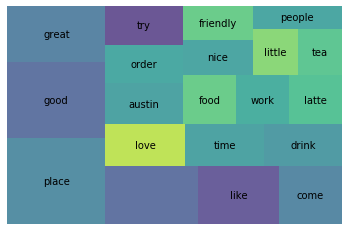

In [17]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=0.8)
plt.axis('off')
plt.show()

In [18]:
shops['coffee_shop_name'].nunique()

79

/home/asura/miniconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


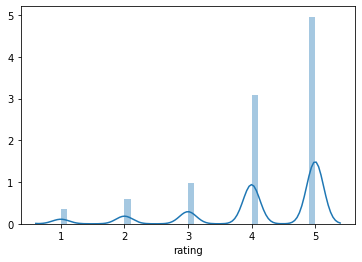

In [19]:
sns.distplot(shops['rating']);

In [20]:
shops.rating.describe()

count    7616.000000
mean        4.169118
std         1.065311
min         1.000000
25%         4.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


#### Bad Word Count (Rating < 4, and Rank <= 20)

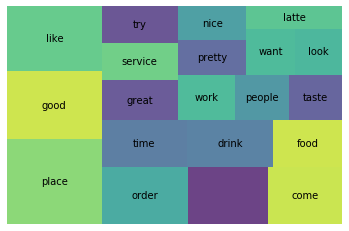

In [21]:
wc_bad = count(shops[shops['rating'] < 4]['tokens'])
wc_top20_bad = wc_bad[wc_bad['rank'] <= 20]

squarify.plot(sizes=wc_top20_bad['pct_total'], label=wc_top20_bad['word'], alpha=0.8)
plt.axis('off')
plt.show()

#### Good Word Count

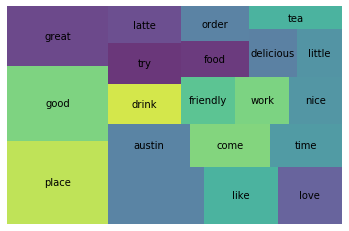

In [22]:
wc_good = count(shops[shops['rating'] >= 4]['tokens'])
wc_top20_good = wc_good[wc_good['rank'] <= 20]

squarify.plot(sizes=wc_top20_good['pct_total'], label=wc_top20_good['word'], alpha=0.8)
plt.axis('off')
plt.show()

#### 

In [23]:
wc_bad['appears_in_pct_bad'] = wc_bad['appears_in_pct']
diff = wc_good[['word', 'appears_in_pct']].merge(wc_bad[['word', 'appears_in_pct_bad']], how='outer')
diff.head(20)

,word,appears_in_pct,appears_in_pct_bad
0,place,0.510261,0.511518
1,good,0.480456,0.439024
2,great,0.407980,0.235772
3,,0.246254,0.245257
4,like,0.271661,0.401084
5,love,0.261889,0.142276
6,austin,0.255700,0.165312
7,come,0.240879,0.306233
8,time,0.216612,0.284553
9,drink,0.205049,0.245257


In [24]:
diff['diff'] = diff['appears_in_pct'] - diff['appears_in_pct_bad']
diff.sort_values(by='diff').head(20)

,word,appears_in_pct,appears_in_pct_bad,diff
4,like,0.271661,0.401084,-0.129423
16,order,0.165961,0.294715,-0.128755
131,ask,0.050651,0.149051,-0.098400
29,service,0.140391,0.234417,-0.094026
197,bad,0.037785,0.129404,-0.091619
43,taste,0.106352,0.187669,-0.081318
157,customer,0.044463,0.125339,-0.080876
244,maybe,0.030293,0.103659,-0.073365
86,review,0.077850,0.151084,-0.073234
41,think,0.106840,0.177507,-0.070666


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play the the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

